In [1]:
import torchvision
import numpy
import torch
import argparse
from torch.utils.data import DataLoader
import cv2
from PIL import Image
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from zipfile import ZipFile
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from tqdm import tqdm
import glob
import cv2
import os
import pickle
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_palette(sns.color_palette("flare"))
sns.set_style('darkgrid')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/IR/'

/content/drive/.shortcut-targets-by-id/1Tl96HFVSeiyjt2a5h4f4alX5PQzHwisc/IR


## Preprocessing

In [ ]:
track_metadata_df = pd.read_csv('song_data.csv')
user_play_df = pd.read_csv('10000.txt', sep='\t', header=None, names=['user','song','play_count'])

In [ ]:
# Group track metadata by song ID and get maximum values for each group
unique_track_metadata_df = track_metadata_df.groupby('song_id').max().reset_index()

# Print number of rows and number of unique songs in the new dataframe
num_rows = unique_track_metadata_df.shape[0]
num_unique_songs = len(unique_track_metadata_df['song_id'].unique())
print(f'Number of rows after unique song ID treatment: {num_rows}')
print(f'Number of unique songs: {num_unique_songs}')

# Display the head of the new dataframe
display(unique_track_metadata_df.head())


Number of rows after unique song ID treatment: 999056
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOAAABI12A8C13615F,Afro Jazziac,To Birdland And Hurry,Herbie Mann,2000
1,SOAAABT12AC46860F0,Herre Gud Ditt Dyre Namn Og Ære,Som Den Gyldne Sol Frembryter,Bergen Big Band,0
2,SOAAABX12A8C13FEB2,N.Y.C. Remix,Paris Can´t Wait,Guardner,0
3,SOAAACR12A58A79456,Irresistible,Wowie Zowie,Superchumbo,2002
4,SOAAACY12A58A79663,Untitled 1,Pine Cone Temples,Thuja,0


In [ ]:
display(user_play_df.shape, user_play_df.head())

(2000000, 3)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


Merging the two tables

In [ ]:
# Merge user play data with unique track metadata based on song ID
user_song_list_count = pd.merge(user_play_df, unique_track_metadata_df, 
                                how='left', left_on='song', right_on='song_id')

# Rename the 'play_count' column to 'listen_count'
user_song_list_count.rename(columns={'play_count':'listen_count'}, inplace=True)

# Delete the 'song_id' column from the merged dataframe
del user_song_list_count['song_id']


In [ ]:
user_song_list_count

,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2,Ignorance (Album Version),Ignorance,Paramore,0
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3,What I've Done (Album Version),What I've Done,Linkin Park,2007
1999998,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1,Up,My Worlds,Justin Bieber,2010


In [ ]:
newDf = user_song_list_count[:1]
newDf.drop(0,axis=0,inplace=True)

<ipython-input-9-8c8884c07f33>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newDf.drop(0,axis=0,inplace=True)


In [ ]:
newDf['lyrics'] = []
newDf

,user,song,listen_count,title,release,artist_name,year,lyrics


In [ ]:
newDf = newDf.append(pd.DataFrame({'user':0,	'song':0,	'listen_count':0,	'title':0,	'release':0,	'artist_name':0,	'year':0,	'lyrics':0}, index=[0]))
newDf = newDf.append(pd.DataFrame({'user':0,	'song':1,	'listen_count':0,	'title':0,	'release':0,	'artist_name':0,	'year':0,	'lyrics':0}, index=[0]))
# newDf.append(pd.DataFrame({'user':,	'song':,	'listen_count':,	'title':,	'release':,	'artist_name':,	'year':,	'lyrics':}))
newDf

<ipython-input-25-5a2ab38ce421>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  newDf = newDf.append(pd.DataFrame({'user':0,	'song':0,	'listen_count':0,	'title':0,	'release':0,	'artist_name':0,	'year':0,	'lyrics':0}, index=[0]))
<ipython-input-25-5a2ab38ce421>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  newDf = newDf.append(pd.DataFrame({'user':0,	'song':1,	'listen_count':0,	'title':0,	'release':0,	'artist_name':0,	'year':0,	'lyrics':0}, index=[0]))


,user,song,listen_count,title,release,artist_name,year,lyrics
0,0,0,0,0,0,0,0,0.0
0,0,0,0,0,0,0,0,0.0
0,0,1,0,0,0,0,0,0.0


In [ ]:
Lyrics_df = pd.read_csv('/content/FinalSongLyrics.csv')
songname = Lyrics_df['song Name']
songlyrics = Lyrics_df['lyrics']
mapp = {}
for i in range(len(songname)):
  mapp[songname[i]] = songlyrics[i]

In [ ]:
'The Cove' in Lyrics_df['song Name']

False

In [ ]:
finallyrics = []
mergedsongnames = user_song_list_count['title']
for i in mergedsongnames:
  if i in mapp.keys():
    finallyrics.append(mapp[i])

print('Started with',len(user_song_list_count),'songs')
print('Finally',len(finallyrics),'songs')

Started with 2000000 songs
Finally 573268 songs


In [ ]:
for i in tqdm(range(len(user_song_list_count))):
  if user_song_list_count['title'][i] in mapp:
    df1 = newDf
    df2 = pd.DataFrame({'user':user_song_list_count['user'][i],	'song':user_song_list_count['song'][i],	'listen_count':user_song_list_count['listen_count'][i],	'title':user_song_list_count['title'][i],	'release':user_song_list_count['release'][i],	'artist_name':user_song_list_count['artist_name'][i],	'year':user_song_list_count['year'][i],	'lyrics':mapp[user_song_list_count['title'][i]]}, index = [0])
    newDf = pd.concat([df1,df2])

<ipython-input-19-6319cedfa118>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(user_song_list_count))):


  0%|          | 0/2000000 [00:00<?, ?it/s]

In [ ]:
newDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573268 entries, 0 to 0
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user          573268 non-null  object
 1   song          573268 non-null  object
 2   listen_count  573268 non-null  int64 
 3   title         573268 non-null  object
 4   release       573268 non-null  object
 5   artist_name   573268 non-null  object
 6   year          573268 non-null  int64 
 7   lyrics        573268 non-null  object
dtypes: int64(2), object(6)
memory usage: 39.4+ MB


fasttext code

In [4]:
!pip install sentence_transformers gensim fasttext datasets accelerate nvidia-ml-py3
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/req_command.py", line 241, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/commands/install.py", line 419, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 481, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/resolvelib

In [ ]:
import fasttext
import fasttext.util

In [ ]:
df = pd.read_csv('user_song_list_index_with_lyrics.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573268 entries, 0 to 573267
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    573268 non-null  int64 
 1   user          573268 non-null  object
 2   song          573268 non-null  object
 3   listen_count  573268 non-null  int64 
 4   title         573268 non-null  object
 5   release       573268 non-null  object
 6   artist_name   573268 non-null  object
 7   year          573268 non-null  int64 
 8   lyrics        573268 non-null  object
dtypes: int64(3), object(6)
memory usage: 39.4+ MB


In [ ]:
fasttext.util.download_model('en', if_exists='ignore')
NON_CONEXTUAL_MODEL_TYPE = 'cc.en.300.bin'
CONEXTUAL_MODEL_TYPE = 'all-mpnet-base-v2'
HUGGING_FACE_SENTENCE_TRANSFORMER_MODEL = 'facebook/bart-base'
BATCH_SIZE = 16
OUT_DIM_DENSE = 768
NUM_EPOCHS = 3

In [ ]:
fasttext_model = fasttext.load_model(NON_CONEXTUAL_MODEL_TYPE)

In [ ]:
# def getSentenceEncodings(sentences, model):
#   a=[]
#   for i in tqdm(sentences):
#     a.append(model.get_sentence_vector(i))
#   return a

def getSentenceEncodings(sentences, model):
  a={}
  unq = 1
  count = 'T'+str(unq)
  for i in tqdm(sentences):
    a[count] = model.get_sentence_vector(i)
    unq += 1
    count = 'T'+str(unq)
  return a

In [ ]:
df1 = df[:400000]

In [ ]:
xyz = getSentenceEncodings(df1['lyrics'],fasttext_model)

<ipython-input-11-58a9910ad2f6>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(sentences):


  0%|          | 0/400000 [00:00<?, ?it/s]

In [ ]:
len(xyz['L1'])

300

In [ ]:
wxyz = pd.DataFrame(xyz)
wxyz

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L399991,L399992,L399993,L399994,L399995,L399996,L399997,L399998,L399999,L400000
0,0.013271,-0.016372,0.012538,0.006611,-0.007878,0.010756,0.003254,0.003138,-0.011276,0.005377,...,-0.004683,-0.001017,0.001736,-0.005048,0.005317,0.004937,0.005219,0.002462,-0.016283,-0.003341
1,-0.045020,-0.012811,-0.005735,-0.003212,-0.010194,-0.018138,-0.000557,0.010185,0.004814,0.016932,...,-0.015507,-0.013294,-0.002625,0.000229,-0.001993,-0.009058,-0.019594,-0.002113,-0.002188,-0.017493
2,-0.008184,0.019531,0.014831,0.007064,-0.004973,0.012179,0.020075,0.010351,0.010064,0.022227,...,0.000363,0.010109,0.012143,-0.003493,0.012844,0.007886,0.011422,0.006928,-0.007557,0.015066
3,0.049428,0.062848,0.052208,0.051910,0.053964,0.041889,0.066728,0.044348,0.071025,0.052016,...,0.055831,0.050274,0.053872,0.044330,0.047500,0.045286,0.055735,0.051164,0.048147,0.048457
4,-0.025430,-0.048744,-0.050455,-0.043352,-0.026041,-0.050589,-0.060180,-0.047285,-0.037516,-0.041869,...,-0.033644,-0.050070,-0.044934,-0.039319,-0.051139,-0.042509,-0.054007,-0.057308,-0.048819,-0.039646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.011824,0.007186,0.011746,0.003292,-0.002633,0.006427,0.006081,-0.005579,0.004690,0.010672,...,0.011560,0.011842,0.002910,0.000924,0.019841,0.009938,0.014930,0.012025,0.001404,-0.001937
296,0.008902,0.004755,0.024750,0.016008,0.012421,0.004401,0.008697,0.004205,0.012424,0.031276,...,0.005994,0.008086,0.016509,-0.000545,0.024154,0.009959,0.017716,0.009053,0.007701,0.015873
297,0.109844,0.076732,0.102944,0.080145,0.091934,0.103065,0.066322,0.096786,0.090652,0.083986,...,0.097061,0.087740,0.089876,0.084966,0.086344,0.099480,0.096996,0.108189,0.097924,0.094160
298,-0.011184,-0.012622,-0.013231,-0.018713,-0.019009,-0.001401,-0.002294,-0.010736,-0.003251,-0.030298,...,-0.010100,-0.014261,-0.023649,-0.004056,-0.037487,-0.020501,-0.016763,-0.011141,-0.014155,-0.015337


In [ ]:
zz= wxyz.transpose()

In [ ]:
zz

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
L1,0.013271,-0.045020,-0.008184,0.049428,-0.025430,-0.008316,-0.042515,-0.007629,0.009298,0.005643,...,0.040770,0.004803,-0.081934,0.003525,0.007332,0.011824,0.008902,0.109844,-0.011184,-0.009427
L2,-0.016372,-0.012811,0.019531,0.062848,-0.048744,-0.004653,0.018181,0.012372,0.000361,0.004930,...,0.053420,0.011346,-0.070962,-0.015696,-0.003050,0.007186,0.004755,0.076732,-0.012622,-0.013976
L3,0.012538,-0.005735,0.014831,0.052208,-0.050455,-0.028510,-0.014352,-0.001575,0.032187,-0.009249,...,0.039667,0.001909,-0.084709,0.002950,0.000785,0.011746,0.024750,0.102944,-0.013231,-0.022918
L4,0.006611,-0.003212,0.007064,0.051910,-0.043352,-0.016626,-0.010534,0.005963,0.012790,-0.011219,...,0.055538,-0.006234,-0.074993,0.011612,-0.014475,0.003292,0.016008,0.080145,-0.018713,-0.018112
L5,-0.007878,-0.010194,-0.004973,0.053964,-0.026041,0.001560,-0.028458,-0.002844,0.001340,-0.009168,...,0.055336,-0.015158,-0.092895,0.005416,0.001914,-0.002633,0.012421,0.091934,-0.019009,-0.037908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L399996,0.004937,-0.009058,0.007886,0.045286,-0.042509,-0.012438,-0.016632,0.002289,0.013025,-0.004259,...,0.044581,0.000138,-0.083120,-0.000508,-0.008914,0.009938,0.009959,0.099480,-0.020501,-0.018922
L399997,0.005219,-0.019594,0.011422,0.055735,-0.054007,-0.013626,-0.000850,0.005102,0.016623,-0.007556,...,0.041461,0.005483,-0.086268,0.004399,-0.007193,0.014930,0.017716,0.096996,-0.016763,-0.023461
L399998,0.002462,-0.002113,0.006928,0.051164,-0.057308,-0.013618,-0.008647,-0.007001,0.014162,-0.014268,...,0.047185,0.002287,-0.082895,0.001709,-0.003472,0.012025,0.009053,0.108189,-0.011141,-0.007705
L399999,-0.016283,-0.002188,-0.007557,0.048147,-0.048819,0.001698,-0.006622,0.005799,0.012735,-0.007225,...,0.036281,-0.010965,-0.084094,-0.014944,-0.011114,0.001404,0.007701,0.097924,-0.014155,0.001783


In [ ]:
# dff = pd.concat([df1,pd.DataFrame(getSentenceEncodings(df['lyrics'],fasttext_model)).T], axis=0)
df.reset_index(drop=True, inplace=True)
zz.reset_index(drop=True, inplace=True)
dff = pd.concat([df,zz], ignore_index=True, axis=1)

In [ ]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573268 entries, 0 to 573267
Columns: 309 entries, 0 to 308
dtypes: float32(300), int64(3), object(6)
memory usage: 695.4+ MB


In [ ]:
dff1 = dff.drop([8], axis=1)

In [ ]:
dff1.to_csv('/content/user_song_list_with_lyrics_embeddings.csv')

### Generating embeddings for Title

In [5]:
df = pd.read_csv('user_song_list_with_lyrics_embeddings1.csv')

In [6]:
df

,Unnamed: 0.1,Unnamed: 0,0,1,2,3,4,5,6,7,...,299,300,301,302,303,304,305,306,307,308
0,0,0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,...,0.040770,0.004803,-0.081934,0.003525,0.007332,0.011824,0.008902,0.109844,-0.011184,-0.009427
1,1,1,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,...,0.053420,0.011346,-0.070962,-0.015696,-0.003050,0.007186,0.004755,0.076732,-0.012622,-0.013976
2,2,2,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005,...,0.039668,0.001909,-0.084709,0.002950,0.000785,0.011746,0.024750,0.102944,-0.013231,-0.022918
3,3,3,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,...,0.055538,-0.006234,-0.074993,0.011612,-0.014475,0.003292,0.016008,0.080145,-0.018713,-0.018112
4,4,4,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOJPFQG12A58A7833A,1,Clarity,As/Is: Cleveland/Cincinnati_ OH - 8/03-8/04/04,John Mayer,0,...,0.055336,-0.015158,-0.092895,0.005416,0.001914,-0.002633,0.012421,0.091934,-0.019009,-0.037908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,399995,399995,0,0b9df04f418efbd073138c38d23eedc1f8f8cf0b,SOLZEED12A6D4FA8C9,1,You Know I'm No Good,You Know I'm No Good - GFK Version,Amy Winehouse,2006,...,0.044581,0.000138,-0.083120,-0.000508,-0.008914,0.009938,0.009959,0.099480,-0.020501,-0.018922
399996,399996,399996,0,0b9df04f418efbd073138c38d23eedc1f8f8cf0b,SOTPQFM12AB017AC9E,1,I'm Not A Loser,Somery,Descendents,1982,...,0.041461,0.005483,-0.086268,0.004399,-0.007193,0.014930,0.017716,0.096996,-0.016763,-0.023461
399997,399997,399997,0,0b9df04f418efbd073138c38d23eedc1f8f8cf0b,SOUKJBT12A6701C4D6,1,Speed Of Sound,Speed Of Sound,Coldplay,2005,...,0.047185,0.002287,-0.082895,0.001709,-0.003472,0.012025,0.009053,0.108189,-0.011141,-0.007705
399998,399998,399998,0,0b9df04f418efbd073138c38d23eedc1f8f8cf0b,SOVZCSJ12A8AE476EF,1,Another Time Another Place,Boy,U2,1994,...,0.036281,-0.010965,-0.084094,-0.014944,-0.011114,0.001404,0.007701,0.097924,-0.014155,0.001783


In [ ]:
 df = df.dropna()

In [11]:
xyz = getSentenceEncodings(df['4'],fasttext_model)

<ipython-input-8-550c1cf0a988>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(sentences):


  0%|          | 0/400000 [00:00<?, ?it/s]

In [ ]:
len(xyz['T1'])

300

In [12]:
wxyz = pd.DataFrame(xyz)
zz= wxyz.transpose()

In [7]:
zz = pd.read_csv('Temporary_Titles_embeddings.csv')

In [8]:
df.reset_index(drop=True, inplace=True)
zz.reset_index(drop=True, inplace=True)
dff = pd.concat([df,zz], ignore_index=True, axis=1)

In [9]:
dff

,0,1,2,3,4,5,6,7,8,9,...,601,602,603,604,605,606,607,608,609,610
0,0,0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,...,-0.016020,0.051514,0.112377,-0.101461,-0.009572,0.013096,-0.002825,0.099568,-0.025742,0.019022
1,1,1,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,...,0.026751,0.033598,0.061161,-0.149784,0.123100,0.025756,0.042525,0.082381,0.098697,0.044474
2,2,2,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005,...,-0.030281,-0.082567,0.082334,-0.025078,0.001777,-0.088783,-0.084012,0.079264,-0.034398,0.011239
3,3,3,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,...,0.106692,-0.024937,0.020670,-0.038837,-0.064640,-0.012014,-0.012017,0.038513,0.001047,-0.035434
4,4,4,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOJPFQG12A58A7833A,1,Clarity,As/Is: Cleveland/Cincinnati_ OH - 8/03-8/04/04,John Mayer,0,...,0.102550,-0.009999,0.110747,0.005159,-0.012548,-0.073592,0.056958,0.083830,-0.025329,0.052146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,399995,399995,0,0b9df04f418efbd073138c38d23eedc1f8f8cf0b,SOLZEED12A6D4FA8C9,1,You Know I'm No Good,You Know I'm No Good - GFK Version,Amy Winehouse,2006,...,0.061916,0.018743,-0.070078,-0.018737,0.013307,0.019532,0.030768,0.066467,-0.008994,-0.035382
399996,399996,399996,0,0b9df04f418efbd073138c38d23eedc1f8f8cf0b,SOTPQFM12AB017AC9E,1,I'm Not A Loser,Somery,Descendents,1982,...,0.049863,-0.030227,-0.035066,0.027614,0.012954,-0.000881,0.041341,0.049938,-0.009197,-0.014366
399997,399997,399997,0,0b9df04f418efbd073138c38d23eedc1f8f8cf0b,SOUKJBT12A6701C4D6,1,Speed Of Sound,Speed Of Sound,Coldplay,2005,...,0.019711,0.004395,0.084196,-0.029760,-0.030175,-0.036991,0.023476,0.068651,-0.057120,-0.057801
399998,399998,399998,0,0b9df04f418efbd073138c38d23eedc1f8f8cf0b,SOVZCSJ12A8AE476EF,1,Another Time Another Place,Boy,U2,1994,...,0.105329,0.005171,0.007614,-0.018521,-0.003246,-0.009801,-0.015022,0.041709,0.015949,0.004563


In [10]:
y = dff[5]
dff = dff.drop([5], axis=1)
dff['listen count'] = y

In [12]:
dff.to_csv('with_title_embeddings.csv')

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

songnames = user_song_list_count['']
sentiment = []
for i in range(len(songnames)):
  sentiment[i] = analyzer.polarity_scores(songnames[i])

user_song_list_count['Song Title Sentiment'] = sentiment

In [ ]:
user_song_list_count

## EDA

In [ ]:
user_song_list_count

,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2,Ignorance (Album Version),Ignorance,Paramore,0
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3,What I've Done (Album Version),What I've Done,Linkin Park,2007
1999998,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1,Up,My Worlds,Justin Bieber,2010


In [ ]:
user_song_list_count.describe()

,listen_count,year
count,2.000000e+06,2.000000e+06
mean,3.045485e+00,1.634524e+03
std,6.579720e+00,7.739475e+02
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.984000e+03
50%,1.000000e+00,2.002000e+03
75%,3.000000e+00,2.007000e+03
max,2.213000e+03,2.010000e+03


In [ ]:
user_song_list_count.listen_count.describe().T

count    2.000000e+06
mean     3.045485e+00
std      6.579720e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      2.213000e+03
Name: listen_count, dtype: float64

We observe that there was a song which was played 2213 times by a single user

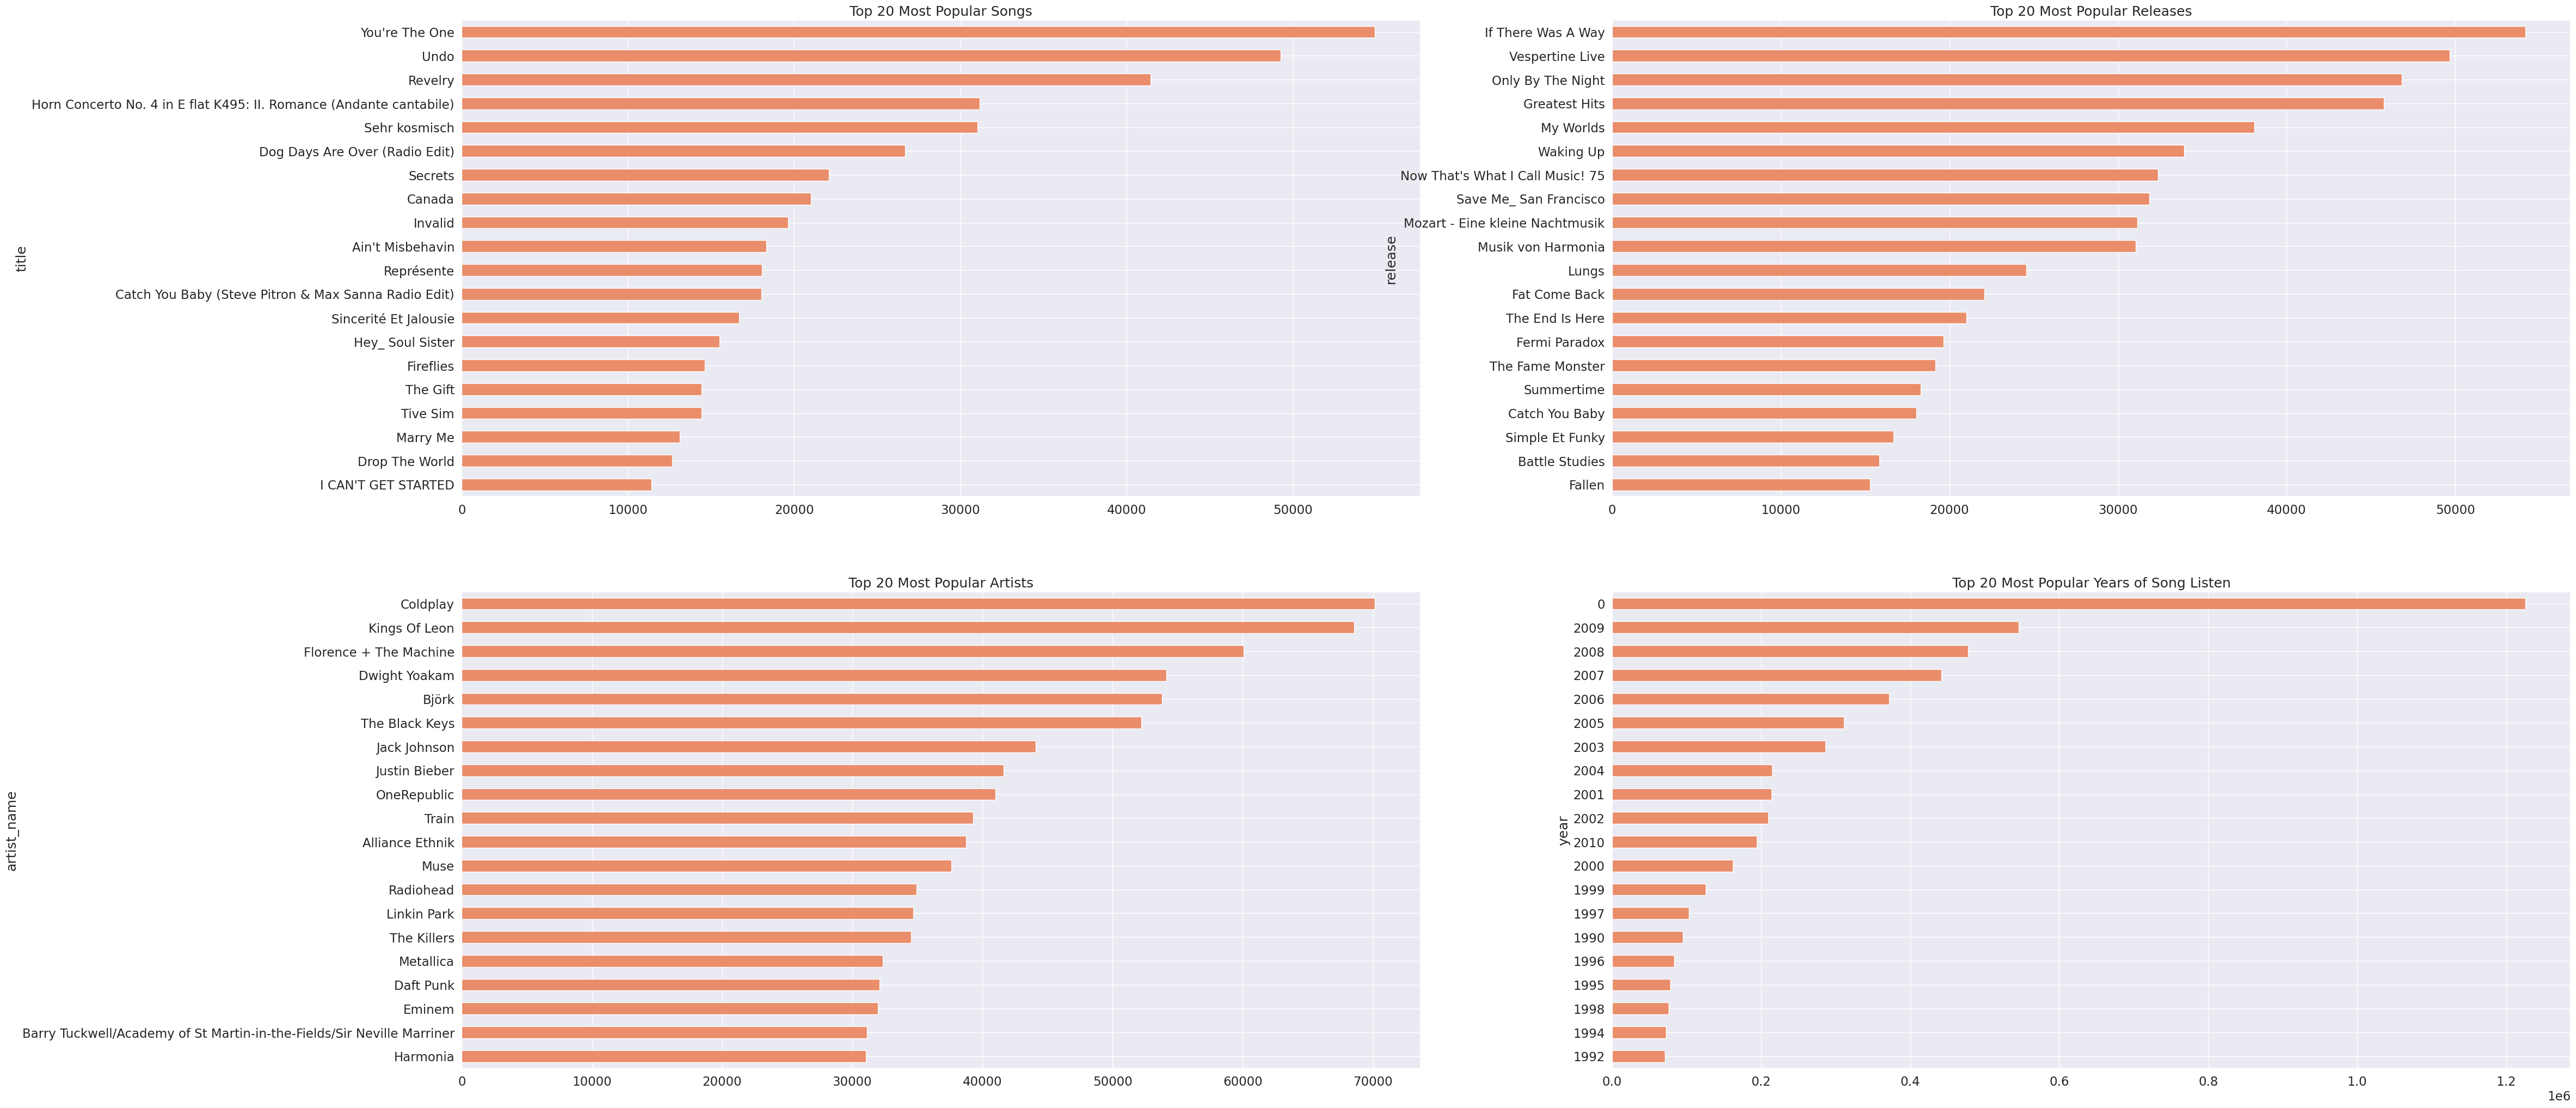

In [ ]:
# Create a figure with four subplots
fig = plt.figure(figsize=(50, 25))
a1 = fig.add_subplot(221)
a2 = fig.add_subplot(222)
a3 = fig.add_subplot(223)
a4 = fig.add_subplot(224)

# Get top 20 most popular songs, releases, artists, and years from user play data
popular_songs = user_song_list_count[['title', 'listen_count']].groupby('title').sum() \
                    .sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
popular_release = user_song_list_count[['release', 'listen_count']].groupby('release').sum() \
                    .sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
popular_artist = user_song_list_count[['artist_name', 'listen_count']].groupby('artist_name').sum() \
                    .sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
popular_year = user_song_list_count[['year', 'listen_count']].groupby('year').sum() \
                    .sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')

# Create horizontal bar charts for each of the top 20 lists and add to the subplots
f1 = popular_songs.plot(kind='barh', title='Top 20 Most Popular Songs', legend=False, ax=a1)
f2 = popular_release.plot(kind='barh', title='Top 20 Most Popular Releases', legend=False, ax=a2)
f3 = popular_artist.plot(kind='barh', title='Top 20 Most Popular Artists', legend=False, ax=a3)
f4 = popular_year.plot(kind='barh', title='Top 20 Most Popular Years of Song Listen', legend=False, ax=a4)

# Rotate x-axis tick labels and add y-axis labels to each subplot
# for f in [f1, f2, f3, f4]:
#     f.set_xticks(f.get_xticks())
#     f.set_xticklabels(f.get_xticklabels(), fontsize=8, rotation='vertical')
#     f.set_ylabel('Item count')
#     f.margins(x=0.1)

# Display the figure
plt.show()

## Popularity based ranking

In [ ]:
def create_popularity_recommendation(train_df, user_col, item_col, n=10):
    # group the train data by unique items and count the number of user IDs for each item
    train_grouped = train_df.groupby([item_col]).agg({user_col: 'count'}).reset_index()
    train_grouped.rename(columns={user_col: 'score'}, inplace=True)
    
    # sort the items based on their scores
    train_sorted = train_grouped.sort_values(['score', item_col], ascending=[False, True])
    
    # assign a rank based on the scores
    train_sorted['rank'] = train_sorted['score'].rank(ascending=False, method='first')
        
    # get the top n recommendations
    popular_recommendations = train_sorted.head(n)
    return popular_recommendations


In [ ]:
recommendations = create_popularity_recommendation(user_song_list_count,'user','title', 15)
display(recommendations)

,title,score,rank
6837,Sehr kosmisch,8277,1.0
8726,Undo,7032,2.0
1965,Dog Days Are Over (Radio Edit),6949,3.0
9497,You're The One,6729,4.0
6499,Revelry,6145,5.0
6826,Secrets,5841,6.0
3438,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385,7.0
2596,Fireflies,4795,8.0
3323,Hey_ Soul Sister,4758,9.0
8495,Tive Sim,4548,10.0


In [ ]:
display(create_popularity_recommendation(user_song_list_count,'user','artist_name', 10)) 

,artist_name,score,rank
649,Coldplay,29422,1.0
2850,The Black Keys,19862,2.0
1651,Kings Of Leon,18747,3.0
1107,Florence + The Machine,18112,4.0
1370,Jack Johnson,17801,5.0
2946,The Killers,16063,6.0
2374,Radiohead,14890,7.0
736,Daft Punk,14715,8.0
2073,Muse,14005,9.0
1554,Justin Bieber,13959,10.0


## Item Similarity Based reccomendation

In [ ]:
#we are using the class for Item-Similarity created by Siraj Raval. Here is the link - https://github.com/llSourcell/recommender_live

class ItemSimilarityRecommender():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
        return item_users
        
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))

        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()

        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df

    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()

        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list

        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations
 

In [ ]:
def item_based(user_song_list, track_col, play_col, user_id):
    # Compute total number of plays across all songs
    total_play_count = user_song_list[play_col].sum()

    # Compute number of plays for the given track and select the top 5,000 songs
    top_songs = user_song_list[[track_col, play_col]].groupby(track_col).sum() \
                    .nlargest(n=5000, columns=play_col)

    print('5,000 most popular songs represents {:3.2%} of total listen.'.format(float(top_songs.sum())/total_play_count))

    # Compute the subset of users who have listened to the top 5,000 songs
    user_subset = user_song_list.loc[user_song_list[track_col].isin(top_songs.index), user_id].unique()

    # Compute the subset of user-song pairs for the top 5,000 songs
    user_song_list_sub = user_song_list[user_song_list[track_col].isin(top_songs.index)]

    return user_song_list_sub

In [ ]:
result = item_based(user_song_list_count, 'song', 'listen_count', 'user')
display(result.head())

5,000 most popular songs represents 81.88% of total listen.


,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [ ]:
is_model = ItemSimilarityRecommender()
is_model.create(result, 'user', 'title')

# Select a random user to recommend songs for
user_id = list(result.user)[7]

# Get the songs listened to by the selected user
user_items = is_model.get_user_items(user_id)

# Recommend songs for the selected user using personalized model
recommendations = is_model.recommend(user_id)
print(recommendations)

In [ ]:
display(result[(result.user==user_id) & (result.listen_count>5)])

# Matrix factorization based recommendations

In [ ]:
def compute_estimated_matrix(uTest, K, num_recommendations):
  urm = coo_matrix((data_array, (row_array, col_array)), dtype=float)
  U, s, Vt = svds(urm, K)

  dim = (len(s), len(s))
  S = np.zeros(dim, dtype=np.float32)

  np.fill_diagonal(S, np.sqrt(s))

  U = csc_matrix(U, dtype=np.float32)
  S = csc_matrix(S, dtype=np.float32)
  Vt = csc_matrix(Vt, dtype=np.float32)

  rightTerm = S.dot(Vt) 
  max_recommendation = 250
  estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
  recommendRatings = np.zeros(shape=(MAX_UID, max_recommendation), dtype=np.float16)


  prod = U[uTest, :].dot(rightTerm)
  i = 0
  while i < MAX_PID:
      estimatedRatings[uTest, i] = prod[0,i]
      i += 1
  i = 0
  while i < max_recommendation:
      recommendRatings[uTest, i] = (-estimatedRatings[uTest, :]).argsort()[i]
      i += 1

  num_recommendations = 10

  print("Recommendation for user id {}".format(uTest))
  rank_value = 1
  i = 0
  while (rank_value < num_recommendations + 1) and (i < max_recommendation):
      so = int(recommendRatings[uTest, i])
      if (song_set.user[(song_set.so_index_value == so) & (song_set.us_index_value == uTest)].count()==0):
          song_details = song_set[(song_set.so_index_value == so)].drop_duplicates('so_index_value')[['title','artist_name']]
          print("The number {} recommended song is {} BY {}".format(rank_value, 
                                                                list(song_details['title'])[0],
                                                                list(song_details['artist_name'])[0]))
          rank_value += 1
      i += 1

In [ ]:
song_listen = user_song_list_count[['user','listen_count']].groupby('user').sum().reset_index()
song_listen.rename(columns={'listen_count':'total_listen_count'},inplace=True)
song_listen_count_merged = pd.merge(user_song_list_count,song_listen)
song_listen_count_merged['fractional_play_count'] = song_listen_count_merged['listen_count'] / song_listen_count_merged['total_listen_count']

display(song_listen_count_merged[song_listen_count_merged.user =='b80344d063b5ccb3212f76538f3d9e43d87dca9e']\
        [['user','song','listen_count','fractional_play_count']].head())

In [ ]:
user = song_listen_count_merged.user.drop_duplicates().reset_index()
user.rename(columns={'index':'user_index'}, inplace=True)
user['us_index_value'] = list(user.index)

song = song_listen_count_merged.song.drop_duplicates().reset_index()
song.rename(columns={'index':'song_index'}, inplace=True)
song['so_index_value'] = list(song.index)
d6589314c0a9bcbca4fee0c93b14bc402363afea
song_set = pd.merge(song_listen_count_merged, song)
song_set = pd.merge(song_set, user)
mat_candidate = song_set[['us_index_value', 'so_index_value', 'fractional_play_count']]

data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array =mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

display(data_sparse)

print('User used to performed the item similarity based recommendations earlie:.')
display(user[user.user =='b80344d063b5ccb3212f76538f3d9e43d87dca9e'])

In [ ]:
K=50

uTest = 4
num_recommendations = 10

compute_estimated_matrix(uTest, K, num_recommendations)